In [191]:
import pyqubo
from pyqubo import Array, Binary, Constraint, Placeholder
import numpy as np
import pandas as pd


N, K = 2,6
T = 4
z = 0.05
M = 100
eps = 0.1


df = pd.read_csv('returns_data.txt',delim_whitespace=True)

Rraw = df.values.T

# Select the first N,T assets and scenarios, you may choose a different strategy if you would like to do so.
reward = Rraw[:N,:T]

# Expected return of each asset
Mu = np.mean(reward, axis = 1)

Sigma = np.cov(reward)
# Covariance matrix of asset returns

R = reward.T

In [192]:
def binary2integer_norm(z):
    try:
        K = len(z)
    except:
        return 1/2 * z
    return sum([2**((k+1)-1-K)*z[k] for k in range(0,K)])

# Slack, nonbasic and other variables

z_full = Array.create("z_full", shape= (N,K), vartype="BINARY")

r_eps_norm = Array.create("r_eps", shape=(K, 1), vartype="BINARY")

A_norm =  Array.create("A_norm", shape=(K, 1), vartype="BINARY")
A_max = z
A = A_max*binary2integer_norm(A_norm)

B_norm =  Array.create("B_norm", shape=(T, K), vartype="BINARY")
B_max = np.max(R, axis=1) + z + M 

C_norm =  Array.create("C_norm", shape=(K, 1), vartype="BINARY")
C_max = eps*T
C = C_max*binary2integer_norm(C_norm)

y = Array.create("y", shape=(T, 1), vartype="BINARY")

r_eps = z*(-1 + binary2integer_norm(r_eps_norm))

def IV(n):
    return (n*n - n)/2 + n

In [193]:
H_var = 0
for i in range(N):
    for j in range(N):
        H_var += binary2integer_norm(z_full[i])*binary2integer_norm(z_full[j])*Sigma[i,j]

In [194]:
H_exp = 0
for i in range(N):
        H_exp += Mu[i]*binary2integer_norm(z_full[i])

In [195]:
L1 = 100
L2s = [100]*T
L3 = 100
L4 = 1000
H1 = L1*Constraint((-r_eps[0] - z + A[0])**2, "H1")

H2 = sum([L2s[t]*Constraint((r_eps[0] 
                       - sum([R[t,j]*binary2integer_norm(z_full[j]) for j in range(N)]) 
                       - M*(1-y[t][0])+1-1 
                       + B_max[t]*binary2integer_norm(B_norm[t]))**2 , "H2_{}".format(t)) for t in range(T)])

H3 = L3*Constraint(((1-eps)*T - sum(y)[0] + C[0] )**2, "H3")

H4 = L4*Constraint((sum([binary2integer_norm(z_full[i]) for i in range(N)])-1)**2, "H4")

In [196]:
H = H_var - H_exp + (H1 +1-1) + (H2+1-1) + (H4+1-1) + (H3+1-1)

In [197]:
model = H.compile()

In [198]:
qubo, offset = model.to_qubo() #H_dict)

In [199]:
from dwave.samplers import SimulatedAnnealingSampler

In [200]:
len(qubo)

895

In [201]:
sampler = SimulatedAnnealingSampler()
sampleset = sampler.sample_qubo(qubo, num_reads=10)
samples = model.decode_sampleset(sampleset)
best_sample = min(samples, key=lambda s: s.energy)

In [202]:
print(best_sample.constraints())

{'H2_2': (False, 0.00011592809759845424), 'H2_0': (False, 0.00010071519761272172), 'H1': (False, -6.2341624917916505e-19), 'H2_1': (False, 0.0001199591688170995), 'H2_3': (False, 0.0006929263919681905), 'H4': (True, 0.0), 'H3': (False, 3.906249999660605e-05)}


In [203]:
z_full_array = np.zeros(shape=z_full.shape)
r_eps_norm_array = np.zeros(shape=r_eps_norm.shape)
A_norm_array = np.zeros(shape=A_norm.shape)
B_norm_array = np.zeros(shape=B_norm.shape)
C_norm_array = np.zeros(shape=C_norm.shape)
y_array = np.zeros(shape=y.shape) 
r_eps_array = np.zeros(shape=r_eps_norm.shape)

In [204]:
import re

key = "B_full[0][1]"


data =best_sample.sample 


# Iterate through the dictionary and populate arrays
for key, value in data.items():
    if key.startswith('B_full'):
        # Use regular expression to extract indices
        indices = [int(idx) for idx in re.findall(r'\[(\d+)\]', key)]
        print(indices)
        B_norm_array[indices[0]][indices[1]] = value
    elif key.startswith('C'):
        indices = [int(idx) for idx in re.findall(r'\[(\d+)\]', key)]
        C_norm_array[indices[0]][indices[1]] = value
    elif key.startswith('A'):
        indices = [int(idx) for idx in re.findall(r'\[(\d+)\]', key)]
        A_norm_array[indices[0]][indices[1]] = value
    elif key.startswith('r_eps'):
        indices = [int(idx) for idx in re.findall(r'\[(\d+)\]', key)]
        r_eps_array[indices[0]][indices[1]] = value
    elif key.startswith('y'):
        indices = [int(idx) for idx in re.findall(r'\[(\d+)\]', key)]
        y_array[indices[0]][indices[1]] = value
    elif key.startswith('z_full'):
        indices = [int(idx) for idx in re.findall(r'\[(\d+)\]', key)]
        z_full_array[indices[0]][indices[1]] = value



In [205]:
ws = [binary2integer_norm(z_full_array[i]) for i in range(N)]

In [206]:
ws

[0.328125, 0.671875]

In [207]:
sum(ws)

1.0

In [214]:
H_var = 0
for i in range(N):
    for j in range(N):
        H_var += binary2integer_norm(z_full_array[i])*binary2integer_norm(z_full_array[j])*Sigma[i,j]

In [215]:
H_exp = 0
for i in range(N):
        H_exp += Mu[i]*binary2integer_norm(z_full_array[i])

In [216]:
H_var

0.00023188283348470079

In [217]:
H_exp

0.008354946868359376

# Validating Simulated Annealing Results

In [305]:
import pyqubo
from pyqubo import Array, Binary, Constraint, Placeholder
import numpy as np
from dwave.samplers import SimulatedAnnealingSampler
len(qubo)

def binary2integer_norm(z):
    try:
        K = len(z)
    except:
        return 1/2 * z
    return sum([2**((k+1)-1-K)*z[k] for k in range(0,K)])

def IV(n):
    return (n*n - n)/2 + n

def f(L1, L3, L4, M, *L2s):
    '''
    L1 = 100
    L2s = [100]*T
    L3 = 100
    L4 = 100
    M = 100
    '''
    
    z_full = Array.create("z_full", shape= (N,K), vartype="BINARY")

    r_eps_norm = Array.create("r_eps", shape=(K, 1), vartype="BINARY")

    A_norm =  Array.create("A_norm", shape=(K, 1), vartype="BINARY")
    A_max = z
    A = A_max*binary2integer_norm(A_norm)

    B_norm =  Array.create("B_norm", shape=(T, K), vartype="BINARY")
    B_max = np.max(R, axis=1) + z + M

    C_norm =  Array.create("C_norm", shape=(K, 1), vartype="BINARY")
    C_max = eps*T
    C = C_max*binary2integer_norm(C_norm)

    y = Array.create("y", shape=(T, 1), vartype="BINARY")

    r_eps = z*(-1 + binary2integer_norm(r_eps_norm))

    H_var = 0
    for i in range(N):
        for j in range(N):
            H_var += binary2integer_norm(z_full[i])*binary2integer_norm(z_full[j])*Sigma[i,j]

    H_exp = 0
    for i in range(N):
            H_exp += Mu[i]*binary2integer_norm(z_full[i])

    H1 = L1*Constraint((-r_eps[0] - z + A[0])**2, "H1")

    H2 = sum([L2s[t]*Constraint((r_eps[0] 
                           - sum([R[t,j]*binary2integer_norm(z_full[j]) for j in range(N)]) 
                           - M*(1-y[t][0])+1-1 
                           + B_max[t]*binary2integer_norm(B_norm[t]))**2 , "H2_{}".format(t)) for t in range(T)])

    H3 = L3*Constraint(((1-eps)*T - sum(y)[0] + C[0] )**2, "H3")

    H4 = L4*Constraint((sum([binary2integer_norm(z_full[i]) for i in range(N)])-1)**2, "H4")

    H = H_var - H_exp + (H1 +1-1) + (H2+1-1) + (H4+1-1) + (H3+1-1)

    model = H.compile()

    qubo, offset = model.to_qubo() #H_dict)

    sampler = SimulatedAnnealingSampler()
    sampleset = sampler.sample_qubo(qubo, num_reads=10)
    samples = model.decode_sampleset(sampleset)
    best_sample = min(samples, key=lambda s: s.energy)
    
    z_full_array = np.zeros(shape=z_full.shape)
    r_eps_norm_array = np.zeros(shape=r_eps_norm.shape)
    A_norm_array = np.zeros(shape=A_norm.shape)
    B_norm_array = np.zeros(shape=B_norm.shape)
    C_norm_array = np.zeros(shape=C_norm.shape)
    y_array = np.zeros(shape=y.shape) 
    r_eps_array = np.zeros(shape=r_eps_norm.shape)

    key = "B_full[0][1]"


    data =best_sample.sample 


    # Iterate through the dictionary and populate arrays
    for key, value in data.items():
        if key.startswith('B_full'):
            # Use regular expression to extract indices
            indices = [int(idx) for idx in re.findall(r'\[(\d+)\]', key)]
            print(indices)
            B_norm_array[indices[0]][indices[1]] = value
        elif key.startswith('C'):
            indices = [int(idx) for idx in re.findall(r'\[(\d+)\]', key)]
            C_norm_array[indices[0]][indices[1]] = value
        elif key.startswith('A'):
            indices = [int(idx) for idx in re.findall(r'\[(\d+)\]', key)]
            A_norm_array[indices[0]][indices[1]] = value
        elif key.startswith('r_eps'):
            indices = [int(idx) for idx in re.findall(r'\[(\d+)\]', key)]
            r_eps_array[indices[0]][indices[1]] = value
        elif key.startswith('y'):
            indices = [int(idx) for idx in re.findall(r'\[(\d+)\]', key)]
            y_array[indices[0]][indices[1]] = value
        elif key.startswith('z_full'):
            indices = [int(idx) for idx in re.findall(r'\[(\d+)\]', key)]
            z_full_array[indices[0]][indices[1]] = value
            
    


    return (sum([i for _,i in list(best_sample.constraints().values())]), z_full_array)

In [326]:
import matplotlib.pyplot as plt

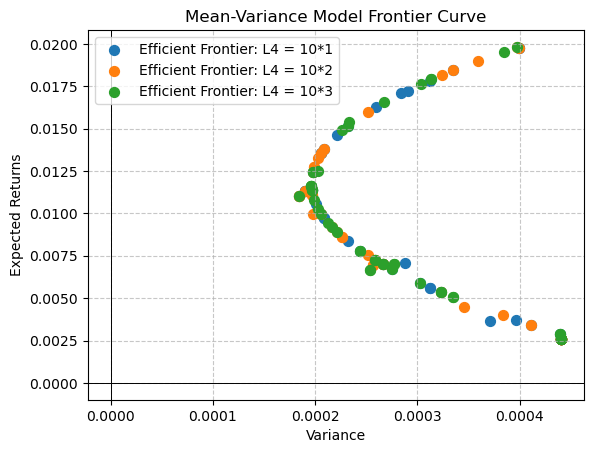

In [339]:
for G in range(1,4):
    H_vars = []
    H_exps = []

    for _ in range(50):
        L1 = 100
        L2s = [100]*T
        L3 = 100
        L4 = 100*G
        M = 100

        Loss, z_full_array = f(L1, L3, L4, M,  *L2s)

        ws = [binary2integer_norm(z_full_array[i]) for i in range(N)]

        H_var = 0
        for i in range(N):
            for j in range(N):
                H_var += binary2integer_norm(z_full_array[i])*binary2integer_norm(z_full_array[j])*Sigma[i,j]

        H_exp = 0
        for i in range(N):
                H_exp += Mu[i]*binary2integer_norm(z_full_array[i])

        H_vars.append(H_var)
        H_exps.append(H_exp)


    # Assuming H_vars and H_exps are your data for variance and expected returns
    # Replace them with your actual data

    # Scatter plot
    plt.scatter(H_vars, H_exps, label='Efficient Frontier: L4 = 10*{}'.format(G), marker='o', s=50)

    # Title and labels
    plt.title('Mean-Variance Model Frontier Curve')
    plt.xlabel('Variance')
    plt.ylabel('Expected Returns')

    # Grid lines
    plt.grid(True, linestyle='--', alpha=0.7)

    # Customize the appearance
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Show the plot


# Add a legend
plt.legend()

plt.show()
import numpy as np

# Optimizing Lagrange Multipliers

In [345]:
Loss, z_full_array = f(L1, L3, L4, M,  *L2s)

In [346]:
Loss

2.6031791873441206

In [ ]:
def numerical_gradient(f, *params, epsilon=1e-7):
    """
    Calculate the numerical gradient of the function f with respect to each parameter.
    """
    gradients = []
    for i in range(len(params)):
        params_plus_epsilon = list(params)
        params_plus_epsilon[i] += epsilon
        params_minus_epsilon = list(params)
        params_minus_epsilon[i] -= epsilon

        gradient_i = (f(*params_plus_epsilon) - f(*params_minus_epsilon)) / (2 * epsilon)
        gradients.append(gradient_i)

    return np.array(gradients)

def gradient_descent(f, initial_params, learning_rate=1e-7, num_iterations=10):
    """
    Perform gradient descent optimization to minimize the function f.
    """
    params = np.array(initial_params, dtype=float)  # Explicitly set data type to float

    for iteration in range(num_iterations):
        grad = numerical_gradient(f, *params)
        params -= learning_rate * grad

        if iteration % 5 == 0:
            print(f'Iteration {iteration}, Value: {f(*params)}')

    return params

# Set initial parameter values
initial_params = [100, 100, 100, 100] + [100] * T  # Replace T with the appropriate value

# Perform gradient descent
optimized_params = gradient_descent(f, initial_params)


In [ ]:
print("Optimized Value:", f(*optimized_params))

In [149]:
print("Optimized Value:", f(*optimized_params))

Optimized Value: 0.0012257928724465485


In [150]:
ws = [binary2integer_norm(z_full_array[i]) for i in range(N)]

In [151]:
ws

[0.65625, 0.34375]

In [152]:
sum(ws)

1.0

In [156]:
np.round(Rraw, 4)

array([[-0.002 ,  0.0449,  0.0108, ..., -0.0327,  0.0167,  0.0186],
       [ 0.0148, -0.0068, -0.0225, ...,  0.0211,  0.0214,  0.0049],
       [-0.0058,  0.0123,  0.0039, ...,  0.024 ,  0.047 ,  0.0134],
       ...,
       [ 0.0593,  0.0789,  0.0782, ...,  0.    ,  0.    ,  0.    ],
       [ 0.0184, -0.0253, -0.0006, ...,  0.0148,  0.0251, -0.0143],
       [-0.0006, -0.0123, -0.0045, ...,  0.0541, -0.0044, -0.0013]])